In [ ]:
!python3 -m pip install opencv-python numpy scikit-learn matplotlib tqdm
!python3 -m pip install yolov8
!python3 -m pip install ultralytics
!python3 -m pip install tensorflow

# Testing using Pre-Trained YOLO model

## Detect other cars during a F1 race

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.conf = 0.45 
model.iou = 0.45

video_path = '/Users/naveenkumar/Desktop/ComputerVisionExperiment/lewis_laps.mov'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)

    predictions = results[0].boxes
    boxes = predictions.xyxy
    scores = predictions.conf
    categories = predictions.cls 

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f"{int(categories[i])}: {scores[i]:.2f}" 
        cv2.putText(frame, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow('YOLOv8 Inference', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

## Detect Cars on Normal Road Traffic

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.conf = 0.8 
model.iou = 0.5

class_names = [    ## COCO class names
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter",
    "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear",
    "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
    "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet",
    "TV", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave",
    "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
    "scissors", "teddy bear", "hair drier", "toothbrush"
]

video_path = '/Users/naveenkumar/Desktop/ComputerVisionExperiment/car_road.mp4'
cap = cv2.VideoCapture(video_path)

# compute IOU to ignore current car
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area

# process frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_height, frame_width, _ = frame.shape

    #ignore boxes larger than 50% of frame and boxes in the bottom 30% of frame
    max_box_area = 0.5 * frame_width * frame_height
    restricted_y_start = int(0.7 * frame_height)
    camera_car_box = [frame_width * 0.4, frame_height * 0.8, frame_width * 0.6, frame_height]

    results = model(frame)

    predictions = results[0].boxes
    boxes = predictions.xyxy.cpu().numpy()
    scores = predictions.conf.cpu().numpy()
    categories = predictions.cls.cpu().numpy()

    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i]
        box_area = (x2 - x1) * (y2 - y1)
        iou = compute_iou([x1, y1, x2, y2], camera_car_box)

        #apply filters to skip unwanted detections
        if box_area > max_box_area or y1 > restricted_y_start or iou > 0.5:
            continue  # Skip processing this box
        
        class_id = int(categories[i])
        class_name = class_names[class_id] if class_id < len(class_names) else "Unknown"

        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f"{class_name}: {scores[i]:.2f}"
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow('YOLOv8 Inference', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# EDA with Pascal VOC data

## Load PASCAL VOC data

In [2]:
import os

# Set paths to relevant directories
base_dir = "/Users/naveenkumar/Desktop/F1 Project/VOC2012/"
image_dir = os.path.join(base_dir, "JPEGImages/")
annotation_dir = os.path.join(base_dir, "Annotations/")
train_file = os.path.join(base_dir, "ImageSets/Main/train.txt")
val_file = os.path.join(base_dir, "ImageSets/Main/val.txt")

## Parse Annotations

In [3]:
import xml.etree.ElementTree as ET

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Image size
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    objects = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        x_min = float(bbox.find('xmin').text)
        y_min = float(bbox.find('ymin').text)
        x_max = float(bbox.find('xmax').text)
        y_max = float(bbox.find('ymax').text)

        # Normalize bounding box
        x_min /= width
        y_min /= height
        x_max /= width
        y_max /= height

        objects.append({
            "class_name": class_name,
            "bbox": [x_min, y_min, x_max, y_max]
        })

    return objects

## Load Images & Annotations

In [4]:
def create_class_mapping(annotations_dir):
    class_names = set()  # Use a set to automatically handle duplicates
    for filename in os.listdir(annotations_dir):
        if filename.endswith(".xml"):
            annotation_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            
            # Find all class names in the annotation
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                class_names.add(class_name)
    
    # Create a class mapping
    class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(class_names))}
    return class_mapping

# Create the class mapping dynamically
class_mapping = create_class_mapping(annotation_dir)
print(class_mapping)  # Check the generated class_mapping dictionary

{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [97]:
import cv2
import numpy as np

def load_data(split_file, image_dir, annotation_dir):
    with open(split_file, "r") as f:
        filenames = [line.strip() for line in f]

    images = []
    labels = []

    for filename in filenames:
        # Load image
        image_path = os.path.join(image_dir, f"{filename}.jpg")
        image = cv2.imread(image_path)
        if image is None:
            continue
        image = cv2.resize(image, (224, 224))  # Resize to fixed size
        images.append(image)

        # Load annotation
        annotation_path = os.path.join(annotation_dir, f"{filename}.xml")
        objects = parse_annotation(annotation_path)

        # Prepare labels
        bboxes = [obj['bbox'] for obj in objects]
        class_names = [obj['class_name'] for obj in objects]

        labels.append({
            "bboxes": bboxes,
            "classes": class_names
        })

    return np.array(images), labels


In [95]:
def denormalize_bbox(bboxes, img_width, img_height):
    denormalized_bboxes = [
        [
            int(bbox[0] * img_width),  # x_min
            int(bbox[1] * img_height),  # y_min
            int(bbox[2] * img_width),  # x_max
            int(bbox[3] * img_height)   # y_max
        ]
        for bbox in bboxes
    ]
    return denormalized_bboxes

# Print some bounding boxes in denormalized form
for i in range(5):  # Adjust range as needed
    print(f"Image {i + 1}:")
    denormalized_bboxes = denormalize_bbox(train_labels[i]['bboxes'], 224, 224)
    print(f"Bounding Boxes (denormalized): {denormalized_bboxes}")
    print(f"Classes: {train_labels[i]['classes']}")
    print("-" * 50)

Image 1:
Bounding Boxes (denormalized): [[23, 44, 211, 212], [70, 22, 129, 84]]
Classes: ['horse', 'person']
--------------------------------------------------
Image 2:
Bounding Boxes (denormalized): [[120, 0, 169, 120], [25, 0, 73, 102]]
Classes: ['bottle', 'bottle']
--------------------------------------------------
Image 3:
Bounding Boxes (denormalized): [[64, 1, 173, 162], [77, 54, 148, 194], [168, 0, 224, 92]]
Classes: ['dog', 'dog', 'dog']
--------------------------------------------------
Image 4:
Bounding Boxes (denormalized): [[4, 0, 211, 117], [26, 43, 81, 184], [92, 16, 113, 48], [121, 16, 145, 46], [64, 17, 82, 46]]
Classes: ['tvmonitor', 'bottle', 'person', 'person', 'person']
--------------------------------------------------
Image 5:
Bounding Boxes (denormalized): [[70, 118, 103, 143], [21, 120, 42, 142]]
Classes: ['car', 'car']
--------------------------------------------------


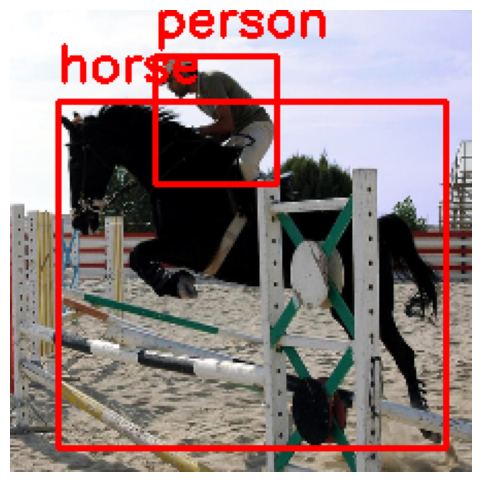

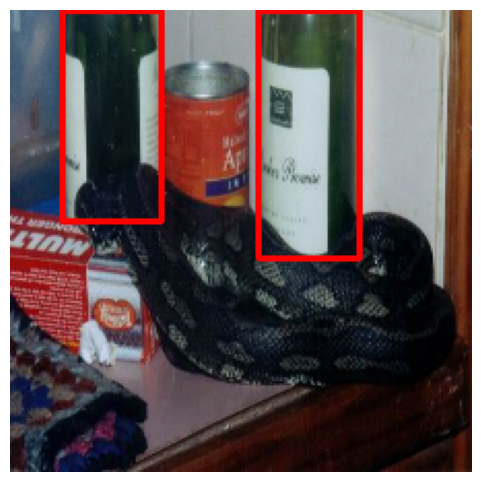

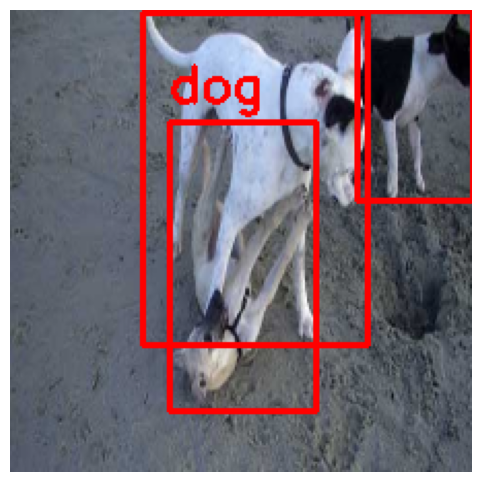

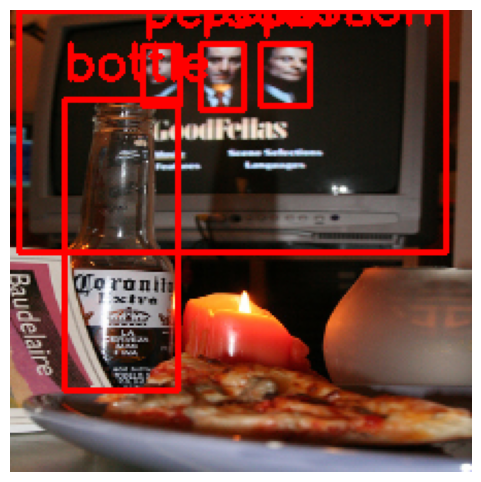

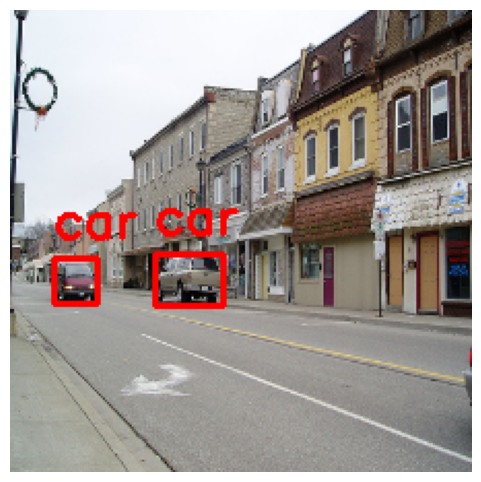

In [98]:
import cv2
import matplotlib.pyplot as plt

def display_sample_images_with_labels(images, labels, class_mapping, num_samples=5):
    for i in range(min(num_samples, len(images))):
        image = images[i]
        label = labels[i]  # A dictionary with keys "bboxes" and "classes"

        # Convert image from BGR (OpenCV) to RGB (Matplotlib)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes and class names on the image
        for bbox, class_name in zip(label["bboxes"], label["classes"]):
            x_min, y_min, x_max, y_max = bbox
            # Convert normalized coordinates back to pixel values
            h, w, _ = image.shape
            x_min = int(x_min * w)
            y_min = int(y_min * h)
            x_max = int(x_max * w)
            y_max = int(y_max * h)

            # Get class ID from class_mapping
            class_id = class_mapping[class_name]

            # Draw a rectangle around the object
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            # Put the class name on the image
            cv2.putText(image_rgb, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

# Load data (if not already loaded)
train_images, train_labels = load_data(train_file, image_dir, annotation_dir)

# Display sample images with bounding boxes and class names
display_sample_images_with_labels(train_images, train_labels, class_mapping)


In [32]:
from collections import Counter

class_counts = Counter([class_name for label in train_labels for class_name in label['classes']])
print("Class distribution:", class_counts)


Class distribution: Counter({'person': 5019, 'chair': 1457, 'car': 1191, 'dog': 768, 'bottle': 749, 'cat': 609, 'bird': 592, 'pottedplant': 557, 'sheep': 509, 'boat': 508, 'aeroplane': 470, 'tvmonitor': 412, 'bicycle': 410, 'sofa': 399, 'horse': 377, 'motorbike': 375, 'diningtable': 373, 'cow': 355, 'train': 327, 'bus': 317})
